In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp

import arviz as az
import numpyro


from hbmep.config import Config
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [2]:
import numpyro.distributions as dist
from hbmep.model import BaseModel


class MixedEffects(BaseModel):
    LINK = "mixed_effects"

    def __init__(self, config: Config):
        super(MixedEffects, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def fn(self, x, a, b, v, L, ell, H):
        return (
            L
            + jnp.where(
                jnp.less(x, a),
                0.,
                -ell + jnp.true_divide(
                    H + ell,
                    jnp.power(
                        1
                        + jnp.multiply(
                            -1
                            + jnp.power(
                                jnp.true_divide(H + ell, ell),
                                v
                            ),
                            jnp.exp(jnp.multiply(-b, x - a))
                        ),
                        jnp.true_divide(1, v)
                    )
                )
            )
        )

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        n_feature0 = n_features[0]

        n_baseline = 1
        n_delta = n_feature0 - 1

        """ Fixed Effects (Baseline) """
        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate("n_baseline", n_baseline):
                a_fixed_mean = numpyro.sample("a_fixed_mean", dist.TruncatedNormal(5, 10, low=0))
                a_fixed_scale = numpyro.sample("a_fixed_scale", dist.HalfNormal(10.0))

                with numpyro.plate(site.n_subject, n_subject):
                    a_fixed = numpyro.sample(
                        "a_fixed", dist.TruncatedNormal(a_fixed_mean, a_fixed_scale, low=0)
                    )

        """ Random Effects (Delta) """
        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate("n_delta", n_delta):
                a_random_mean = numpyro.sample("a_random_mean", dist.Normal(0, 10))
                a_random_scale = numpyro.sample("a_random_scale", dist.HalfNormal(10.0))

                with numpyro.plate(site.n_subject, n_subject):
                    a_random = numpyro.sample("a_random", dist.Normal(a_random_mean, a_random_scale))

                    """ Penalty """
                    penalty_for_negative_a = (jnp.fabs(a_fixed + a_random) - (a_fixed + a_random))
                    numpyro.factor("penalty", -penalty_for_negative_a)

        with numpyro.plate(site.n_response, self.n_response):
            """ Global Priors """
            b_scale_global_scale = numpyro.sample("b_scale_global_scale", dist.HalfNormal(10))
            v_scale_global_scale = numpyro.sample("v_scale_global_scale", dist.HalfNormal(10))

            L_scale_global_scale = numpyro.sample("L_scale_global_scale", dist.HalfNormal(2))
            ell_scale_global_scale = numpyro.sample("ell_scale_global_scale", dist.HalfNormal(10))
            H_scale_global_scale = numpyro.sample("H_scale_global_scale", dist.HalfNormal(10))

            g_1_scale_global_scale = numpyro.sample("g_1_scale_global_scale", dist.HalfNormal(100))
            g_2_scale_global_scale = numpyro.sample("g_2_scale_global_scale", dist.HalfNormal(100))

            with numpyro.plate("n_feature0", n_feature0):
                """ Hyper-priors """
                b_scale_raw = numpyro.sample("b_scale_raw", dist.HalfNormal(scale=1))
                b_scale = numpyro.deterministic("b_scale", jnp.multiply(b_scale_global_scale, b_scale_raw))

                v_scale_raw = numpyro.sample("v_scale_raw", dist.HalfNormal(scale=1))
                v_scale = numpyro.deterministic("v_scale", jnp.multiply(v_scale_global_scale, v_scale_raw))

                L_scale_raw = numpyro.sample("L_scale_raw", dist.HalfNormal(scale=1))
                L_scale = numpyro.deterministic("L_scale", jnp.multiply(L_scale_global_scale, L_scale_raw))

                ell_scale_raw = numpyro.sample("ell_scale_raw", dist.HalfNormal(scale=1))
                ell_scale = numpyro.deterministic("sigma_ell", jnp.multiply(ell_scale_global_scale, ell_scale_raw))

                H_scale_raw = numpyro.sample("H_scale_raw", dist.HalfNormal(scale=1))
                H_scale = numpyro.deterministic("H_scale", jnp.multiply(H_scale_global_scale, H_scale_raw))

                g_1_scale_raw = numpyro.sample("g_1_scale_raw", dist.HalfNormal(scale=1))
                g_1_scale = numpyro.deterministic("g_1_scale", jnp.multiply(g_1_scale_global_scale, g_1_scale_raw))

                g_2_scale_raw = numpyro.sample("g_2_scale_raw", dist.HalfNormal(scale=1))
                g_2_scale = numpyro.deterministic("g_2_scale", jnp.multiply(g_2_scale_global_scale, g_2_scale_raw))

                with numpyro.plate(site.n_subject, n_subject):
                    """ Priors """
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([a_fixed, a_fixed + a_random], axis=1)
                    )

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, jnp.multiply(b_scale, b_raw))

                    v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                    v = numpyro.deterministic(site.v, jnp.multiply(v_scale, v_raw))

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, jnp.multiply(L_scale, L_raw))

                    ell_raw = numpyro.sample("ell_raw", dist.HalfNormal(scale=1))
                    ell = numpyro.deterministic("ell", jnp.multiply(ell_scale, ell_raw))

                    H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                    H = numpyro.deterministic(site.H, jnp.multiply(H_scale, H_raw))

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, jnp.multiply(g_1_scale, g_1_raw))

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, jnp.multiply(g_2_scale, g_2_raw))

        """ Outlier Distribution """
        outlier_prob = numpyro.sample("outlier_prob", dist.Uniform(0., .05))
        outlier_scale = numpyro.sample("outlier_scale", dist.HalfNormal(5))

        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate(site.n_data, n_data):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    self.fn(
                        x=intensity,
                        a=a[subject, feature0],
                        b=b[subject, feature0],
                        v=v[subject, feature0],
                        L=L[subject, feature0],
                        ell=ell[subject, feature0],
                        H=H[subject, feature0]
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[subject, feature0] + jnp.true_divide(g_2[subject, feature0], mu)
                )

                q = numpyro.deterministic("q", outlier_prob * jnp.ones((n_data, self.n_response)))
                bg_scale = numpyro.deterministic("bg_scale", outlier_scale * jnp.ones((n_data, self.n_response)))

                mixing_distribution = dist.Categorical(
                    probs=jnp.stack([1 - q, q], axis=-1)
                )
                component_distributions=[
                    dist.Gamma(concentration=jnp.multiply(mu, beta), rate=beta),
                    dist.HalfNormal(scale=bg_scale)
                ]

                """ Mixture """
                Mixture = dist.MixtureGeneral(
                    mixing_distribution=mixing_distribution,
                    component_distributions=component_distributions
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    Mixture,
                    obs=response_obs
                )

In [3]:
toml_path = "/home/vishu/repos/hbmep-paper/configs/paper/intraoperative/config.toml"

config = Config(toml_path=toml_path)
config.BUILD_DIR = "/home/vishu/repos/hbmep-paper/reports/paper/figures/intraoperative/midline-lateral"

config.MCMC_PARAMS["num_warmup"] = 1000
config.MCMC_PARAMS["num_samples"] = 1000

model = MixedEffects(config=config)

2023-11-17 10:00:53,996 - hbmep.config - INFO - Verifying configuration ...
2023-11-17 10:00:53,997 - hbmep.config - INFO - Success!
2023-11-17 10:00:54,014 - hbmep.model.baseline - INFO - Initialized base_model


In [4]:
src = "/home/vishu/data/hbmep-processed/human/intraoperative/data.csv"
df = pd.read_csv(src)

df[model.features[0]] = df[model.features[0]].replace({"L": "01_L", "M": "02_M"})

ind = ~df[model.response].isna().values.any(axis=-1)
df = df[ind].reset_index(drop=True).copy()

df, encoder_dict = model.load(df=df)


2023-11-17 10:00:54,068 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/paper/figures/intraoperative/midline-lateral
2023-11-17 10:00:54,069 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/paper/figures/intraoperative/midline-lateral
2023-11-17 10:00:54,070 - hbmep.dataset.core - INFO - Processing data ...
2023-11-17 10:00:54,071 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [5]:
src = "/home/vishu/repos/hbmep-paper/reports/paper/intraoperative/midline-lateral/inference.pkl"

with open(src, "rb") as g:
    _, mcmc, posterior_samples = pickle.load(g)


In [6]:
_posterior_samples = posterior_samples.copy()
_posterior_samples["outlier_prob"] = _posterior_samples["outlier_prob"] * 0

prediction_df = model.make_prediction_dataset(df=df, num=2000)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=_posterior_samples)

model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=_posterior_samples, prediction_df=prediction_df, posterior_predictive=posterior_predictive)
model.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive)


2023-11-17 10:00:54,253 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec
2023-11-17 10:02:13,680 - hbmep.utils.utils - INFO - func:predict took: 1 min and 19.43 sec
2023-11-17 10:02:13,680 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-11-17 10:02:20,821 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/figures/intraoperative/midline-lateral/recruitment_curves.pdf
2023-11-17 10:02:20,822 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 7.14 sec
2023-11-17 10:02:20,822 - hbmep.model.baseline - INFO - Rendering posterior predictive checks ...
2023-11-17 10:02:51,255 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/figures/intraoperative/midline-lateral/posterior_predictive_check.pdf
2023-11-17 10:02:51,256 - hbmep.utils.utils - INFO - func:predictive_checks_renderer took: 30.43 sec
2023-11-17 10:02:51,256 - hbmep.utils.utils - INFO - func:render_predictiv

In [7]:
c = (7, 0)

ind = df[model.combination_columns[::-1]].apply(tuple, axis=1).isin([c])
temp_df = df[ind].reset_index(drop=True).copy()



In [8]:
a = posterior_samples[site.a]
a.shape

(4000, 13, 2, 1)

In [9]:
a_map = a.mean(axis=0)
a_map.shape


(13, 2, 1)

In [10]:
mu = posterior_predictive[site.mu]
obs = posterior_predictive[site.obs]


In [11]:
from numpyro.diagnostics import hpdi

obs_hpdi = hpdi(obs, prob=.95)
obs_hpdi.shape


(2, 52000, 1)

In [12]:
a_random_mean = posterior_samples["a_random_mean"].reshape(-1,)
a_random_mean.shape


(4000,)

In [13]:
def fn_prime(x, *args):
    grad = jax.grad(model.fn, argnums=0)
    for _ in range(len(x.shape)):
        grad = jax.vmap(grad)
    return grad(x, *args)


In [14]:
a, b, v, ell, L, H = \
    np.array(posterior_samples[site.a]), np.array(posterior_samples[site.b]), np.array(posterior_samples[site.v]), np.array(posterior_samples["ell"]), np.array(posterior_samples[site.L]), np.array(posterior_samples[site.H])

(subject, n_subject), (features, n_features), (intensity, n_data), = model._collect_regressor(df=prediction_df)
intensity = intensity.reshape(-1, 1)
intensity = np.tile(intensity, (a.shape[0], 1, model.n_response))
feature0 = features[0].reshape(-1,)

params = [a, b, v, ell, L, H]
params = [u[:, subject, feature0] for u in params]

fn_prime_out = fn_prime(intensity, *params)
fn_prime_out = np.array(fn_prime_out)

fn_prime_out.shape


(4000, 52000, 1)

In [63]:
temp_fn_prime_out.shape

(4000, 2000)

In [50]:
a_random = posterior_samples["a_random"][..., 0, 0]
a_random.shape

(4000, 13)

/tmp/ipykernel_224127/1493889291.py:121: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_yticklabels([0., .5, 1.])


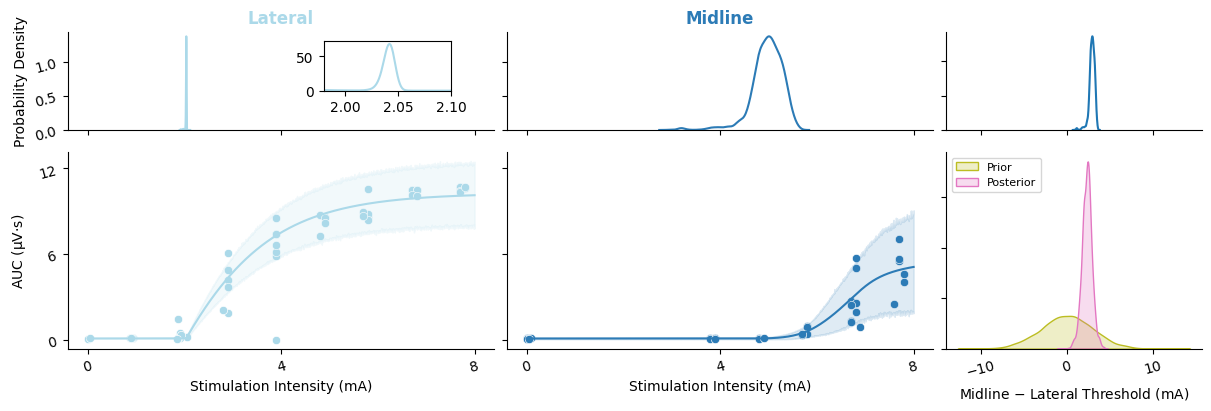

In [55]:
response_colors = [(0.6706, 0.8510, 0.9137), (0.1725, 0.4824, 0.7137)]
subject = 7
cmap = sns.color_palette("tab10")

nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 2 * nrows), squeeze=False, constrained_layout=True, height_ratios=[.5, 1], width_ratios=[1, 1, .6])

counter = 0
for _ in range(nrows * ncols):
    i, j = counter // ncols, counter % ncols
    c = (subject, j)
    ax = axes[i, j]

    if i == 0 and j in {0, 1}: # Thresholds
        sns.kdeplot(a[:, *c, 0], ax=ax, color=response_colors[j])
        if j == 0:
            ins = ax.inset_axes([0.6,0.4,0.3,0.5])
            sns.kdeplot(a[:, *c, 0], ax=ins, color=response_colors[j])
            ins.set_xlabel("")
            ins.set_ylabel("")
            ins.set_xlim(left=1.98, right=2.1)
            ins.set_ylim(bottom=-.03)

        # temp_fn_prime_out = fn_prime_out[:, pred_ind, 0]
        # max_grad = temp_fn_prime_out.max(axis=-1)
        # sns.kdeplot(max_grad, ax=axes[i, 2])

    if i == 1 and j in {0, 1}:
        ind = df[model.combination_columns[::-1]].apply(tuple, axis=1).isin([c])
        temp_df = df[ind].reset_index(drop=True).copy()

        pred_ind = prediction_df[model.combination_columns[::-1]].apply(tuple, axis=1).isin([c])
        temp_pred_df = prediction_df[pred_ind].reset_index(drop=True).copy()

        temp_obs = obs[:, pred_ind, 0]
        temp_mu = mu[:, pred_ind, 0]
        temp_obs_hpdi = obs_hpdi[:, pred_ind, 0]

        sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[0]], ax=ax, color=response_colors[j])
        # sns.lineplot(x=temp_pred_df[model.intensity], y=temp_obs.mean(axis=0), ax=ax)
        sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu.mean(axis=0), color=response_colors[j], ax=ax)
        ax.fill_between(
            temp_pred_df[model.intensity],
            temp_obs_hpdi[0, :],
            temp_obs_hpdi[1, :],
            color=response_colors[j],
            alpha=.15
        )

    if i == 0 and j == 2:
        ax = axes[i, j]
        # sns.kdeplot(a[:, subject, 1, 0] - a[:, subject, 0, 0], ax=ax)
        sns.kdeplot(a_random[:, subject], ax=ax)

    if i == 1 and j == 2:
        d = dist.Normal(0, 3)
        prior = d.sample(model.rng_key, (10000, ))
        sns.kdeplot(prior, ax=ax, color=cmap[-2], fill=True, label="Prior")
        sns.kdeplot(a_random_mean, ax=ax, color=cmap[6], fill=True, label="Posterior")

    counter += 1

# gs = axes[0, 2].get_gridspec()
# for ax in axes[:, -1]:
#     ax.remove()
# axbig = fig.add_subplot(gs[:, -1])
# ax = axbig
# d = dist.Normal(0, 3)
# prior = d.sample(model.rng_key, (10000, ))
# sns.kdeplot(prior, color=cmap[-2], fill=True, label="Prior", ax=ax)
# sns.kdeplot(a_random_mean, color=cmap[6], fill=True, label="Posterior", ax=ax)
# ax.legend(loc="upper left")

axes[0, 0].sharex(axes[1, 0])
axes[0, 1].sharex(axes[1, 0])
axes[1, 1].sharex(axes[1, 0])

axes[0, 2].sharex(axes[1, 2])

# axes[0, 1].sharey(axes[0, 0])
axes[1, 1].sharey(axes[1, 0])

axes[1, 2].legend(loc="upper left", prop = { "size": 8 })

subset = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
for i, j in subset:
    ax = axes[i, j]
    sides = ['right', 'top']
    for side in sides:
        ax.spines[side].set_visible(False)
    ax.tick_params(
        axis='both',
        which='both',
        left=True,
        bottom=True,
        right=False,
        top=False,
        labelleft=False,
        labelbottom=False,
        labelright=False,
        labeltop=False,
        labelrotation=15
    )
    if j == 0:
        ax.tick_params(
            axis='both',
            which='both',
            labelleft=True,
            labelrotation=15
        )
    if i == 1:
        ax.tick_params(
            axis='both',
            which='both',
            labelbottom=True,
            labelrotation=15
        )

# axes[0, 0].set_ylim(bottom=-2)
# axes[0, 1].sharey(axes[0, 0])
axes[0, 0].set_yticklabels([0., .5, 1.])

axes[1, 0].set_yticks([0, 6, 12])
axes[1, 0].set_xticks([0, 4, 8])

axes[1, 2].set_xticks([-10, 0, 10])

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        ax.set_xlabel("")
        ax.set_ylabel("")

axis_label_size = 10
axes[0, 0].set_ylabel("Probability Density", size=axis_label_size)

axes[1, 0].set_ylabel("AUC (µV$\cdot$s)", size=axis_label_size)
axes[1, 0].set_xlabel("Stimulation Intensity (mA)", size=axis_label_size)
axes[1, 1].set_xlabel("Stimulation Intensity (mA)", size=axis_label_size)

axes[1, 2].set_xlabel("Midline $-$ Lateral Threshold (mA)")

axes[0, 0].set_title("Lateral", fontweight="bold", color=response_colors[0])
axes[0, 1].set_title("Midline", fontweight="bold", color=response_colors[1])

# axes[0, 0].set_title("Lateral", fontweight="bold", color=response_colors[0])
# axes[0, 1].set_title("Midline", fontweight="bold", color=response_colors[1])

fig.align_ylabels()

dest = os.path.join(model.build_dir, "midline-lateral.png")
fig.savefig(dest, dpi=600)


In [58]:
dest

'/home/vishu/repos/hbmep-paper/reports/paper/figures/intraoperative/midline-lateral/midline-lateral.png'